### Imports

In [1]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from DataLoaderUrbanSounds import DataLoaderUrbanSounds

### Sample audio

In [2]:
librosa_audio_data, librosa_sample_rate = librosa.load('UrbanSound8K/audio/fold4/7389-1-0-6.wav')

(88200,)


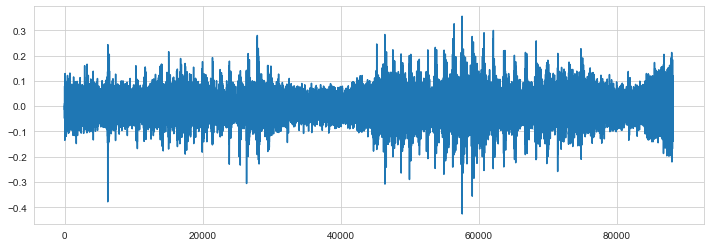

In [3]:
print(librosa_audio_data.shape)
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
ipd.Audio('UrbanSound8K/audio/fold4/7389-1-0-6.wav')

In [4]:
y, sr = librosa.load('UrbanSound8K/audio/fold4/7389-1-0-6.wav', res_type='kaiser_fast')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

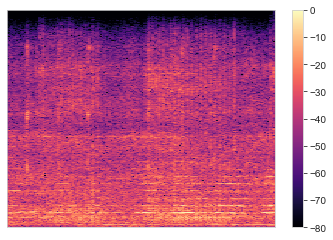

In [5]:
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

### Exploring Metadata

In [6]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<AxesSubplot:>

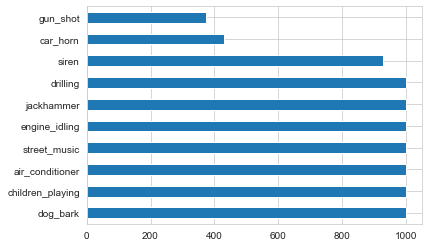

In [7]:
metadata['class'].value_counts().plot(kind='barh')

### Training method

In [8]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


def train(model, num_epochs, num_batch_size, X_train, y_train, X_test, y_test):
    ## Trianing my model
    checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                                   verbose=1, save_best_only=True)
    start = datetime.now()

    # history = model.fit(X_train, y_train, validation_split=0.2, batch_size=num_batch_size, epochs=num_epochs,
    #                     callbacks=[checkpointer], verbose=1)
    history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpointer], verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)

    return history

**instantiate DataLoaderUrbanSound class**

In [9]:
dl = DataLoaderUrbanSounds(40)  # you can choose your own dim

**extract features from all aduio files**


In [10]:
dl.extract_features()

3553it [02:49, 21.99it/s]C:\Users\ditli\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8324it [06:26, 31.21it/s]C:\Users\ditli\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\ditli\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [06:43, 21.67it/s]


**Get Training Data**

In [11]:
# get X (train) data
X, _ = dl.get_train_test_data()

# get y (target) based on the encoder to use
y = dl.get_target_as_one_hot_encoder()
# y = dl.get_target_as_label_encoder()

In [12]:
X = X.reshape(-1, 40, 1)

In [13]:
X.shape

(8732, 40, 1)

**split data into train and test**

In [14]:
X_train, X_test, y_train, y_test = dl.split_to_train_test_data(X, y, 0.3);

## Build model and feed in the data

In [15]:
from keras import Sequential
from keras.layers import Dense, Activation, Dropout

In [16]:
num_labels = y.shape[1]

In [33]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(num_labels, activation='softmax'))


In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
_________________________________________________________________


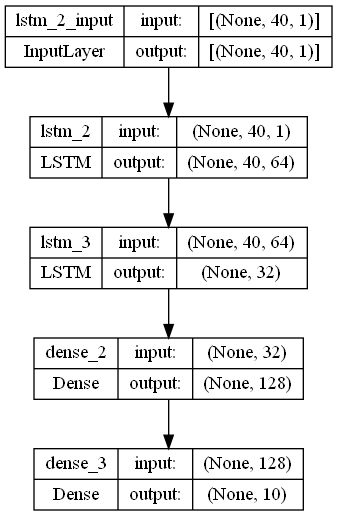

In [35]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [22]:
num_epochs = 50
num_batch_size = 32
import tensorflow as tf
with tf.device("cpu:0"):
    history = train(model, num_epochs, num_batch_size, X_train, y_train, X_test, y_test)

Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 2.0059 - accuracy: 0.2528
Epoch 1: val_loss improved from inf to 1.81643, saving model to saved_models\audio_classification.hdf5
191/191 [==============================] - 11s 46ms/step - loss: 2.0059 - accuracy: 0.2528 - val_loss: 1.8164 - val_accuracy: 0.3198
Epoch 2/50
191/191 [==============================] - ETA: 0s - loss: 1.7351 - accuracy: 0.3572
Epoch 2: val_loss improved from 1.81643 to 1.69621, saving model to saved_models\audio_classification.hdf5
191/191 [==============================] - 9s 47ms/step - loss: 1.7351 - accuracy: 0.3572 - val_loss: 1.6962 - val_accuracy: 0.3725
Epoch 3/50
191/191 [==============================] - ETA: 0s - loss: 1.5319 - accuracy: 0.4457
Epoch 3: val_loss improved from 1.69621 to 1.46166, saving model to saved_models\audio_classification.hdf5
191/191 [==============================] - 9s 48ms/step - loss: 1.5319 - accuracy: 0.4457 - val_loss: 1.4617 - val_accuracy: 0.469

### 'train', 'validation'

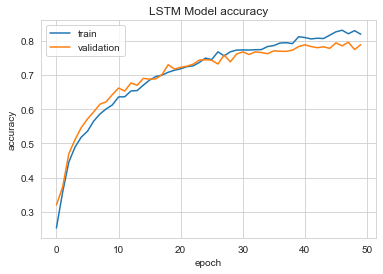

In [32]:
plt.subplots()  # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Loss

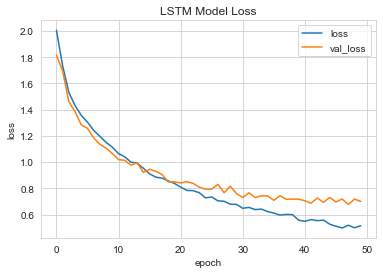

In [31]:
plt.subplots()  # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy)

[0.7003111839294434, 0.7885496020317078]


In [26]:
y_pred = model.predict(X_test)

82/82 [==============================] - 3s 32ms/step


In [27]:

from sklearn import metrics

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [28]:
matrix

array([[298,   0,   7,   0,   2,   7,   6,   5,   2,   9],
       [  1, 105,   1,   0,   3,   3,   1,   4,   2,  13],
       [  7,   1, 231,  13,   8,   2,  12,   7,  17,  10],
       [  8,   1,  42, 167,  11,  10,  10,   3,  26,  19],
       [  6,   3,  12,   4, 253,   6,   2,  15,   2,  13],
       [  3,   0,  14,   1,   2, 258,   1,   4,   4,   5],
       [  0,   0,   9,   1,   2,   2,  92,   0,   1,   1],
       [  6,   1,   8,   1,  18,   1,   0, 239,   1,   6],
       [  2,   3,  15,   2,   2,   3,   1,   1, 246,   2],
       [  9,   9,  22,   7,  23,  12,   1,   3,   9, 177]], dtype=int64)

### Test

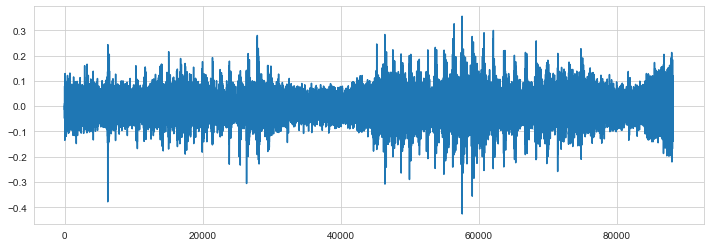

In [29]:
# Original audio with 1 channel
filename = 'UrbanSound8K/audio/fold5/6508-9-0-1.wav'

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
ipd.Audio(filename)

In [30]:
mfccs_scaled_features=dl.get_one_file_features_extractor(filename).reshape(-1,40,1)
predicted_label=np.argmax(model.predict(mfccs_scaled_features),1)
print(predicted_label)
prediction_class = dl.decode_label(predicted_label)
prediction_class

1/1 [==============================] - 0s 51ms/step
[9]


array(['street_music'], dtype='<U16')